# Reconciling PCA and PPCA

PPCA is demeaned and standardized by default


In [247]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from ppca import PPCA

In [252]:
raw_returns = np.random.normal(0.1, 0.01, (250,20)) + 2*np.random.normal(0.1, 0.001, (250,20)) + np.random.normal(0.04, 0.01, (250,20))

In [253]:
raw_returns.shape

(250, 20)

In [255]:
scaler = StandardScaler()
scaler.fit(raw_returns)
returns = scaler.transform(raw_returns)

## Fit Both Models

In [404]:
n_comp = 3

In [405]:
mod = PCA(n_components=n_comp)
modp = PPCA()

In [406]:
mod.fit(returns)
modp.fit(returns, d=n_comp, tol=1e-5)

## Compare Betas

It's ok if signs don't match; that's a feature of PCA.

In [407]:
betas = mod.components_.T
betas.shape

(20, 3)

In [408]:
betasp = modp.C
betasp.shape

(20, 3)

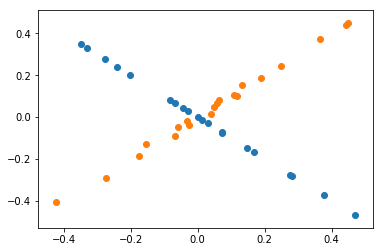

In [409]:
plt.scatter(betas[:,0], betasp[:,0]);
plt.scatter(betas[:,1], betasp[:,1]);

## Compare recovered factor returns

In [410]:
# for each factor, what is the return per date
factor_returns = mod.transform(returns)
factor_returns.shape

(250, 3)

In [411]:
factor_returnsp = modp.transform()
factor_returnsp.shape

(250, 3)

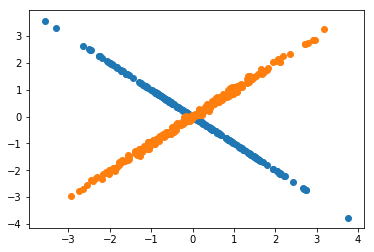

In [412]:
plt.scatter(factor_returns[:,0], factor_returnsp[:,0]);
plt.scatter(factor_returns[:,1], factor_returnsp[:,1]);

## Compare factor volatility

In [413]:
common_factor_volatility = np.std(factor_returns, axis=0)
common_factor_volatilityp = np.std(factor_returnsp, axis=0)

In [414]:
print(common_factor_volatility)
print(common_factor_volatilityp)

[1.22794203 1.19229336 1.17384553]
[1.22794145 1.19218753 1.17333497]


## Compare explained variance

In [415]:
mod.explained_variance_ratio_

array([0.07539208, 0.07107817, 0.06889567])

In [416]:
np.diff(np.append(0, modp.var_exp))

array([0.07569479, 0.07135096, 0.0691122 ])

In [417]:
# for each stock, what is the return attributable to all common factors for each date
common_returns = np.dot(factor_returns, betas.T)

In [418]:
common_returns.shape

(250, 20)

In [419]:
residuals = returns - common_returns

In [420]:
resid_volatility = np.std(residuals, axis=0)

In [421]:
recons = scaler.inverse_transform(common_returns)

In [422]:
recons.shape

(250, 20)

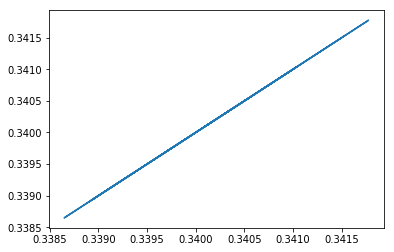

In [423]:
plt.plot(np.mean(recons, axis=0), np.mean(raw_returns, axis=0));

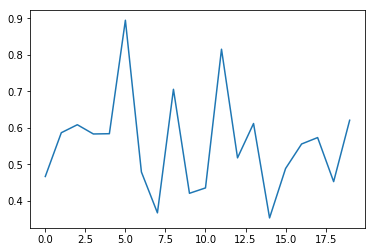

In [427]:
plt.plot((np.std(raw_returns, axis=0)-np.std(recons, axis=0))/np.std(raw_returns, axis=0))

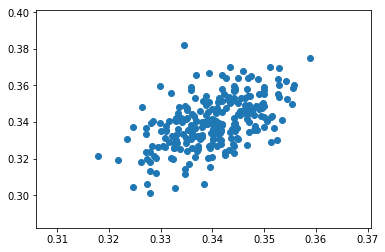

In [428]:
plt.scatter(recons[:,0], raw_returns[:,0])

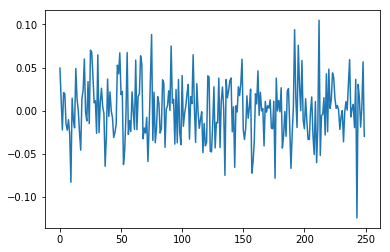

In [429]:
plt.plot((recons[:,0]-raw_returns[:,0])/raw_returns[:,0])